In [38]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from shapely.geometry import Point
from shapely.geometry import MultiPolygon, Polygon, LineString, box
from shapely.ops import polygonize, unary_union
from scipy.spatial import Voronoi, voronoi_plot_2d
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
df_images = pd.read_csv("../resources/mp16_combined.csv");
print(df_images.head());

                 IMG_ID        AUTHOR        LAT         LON  S3_Label  \
0  92_17_5276763594.jpg  42441750@N03  38.685568 -109.532951       1.0   
1  0d_ce_6392770405.jpg  68149505@N00  34.933793  103.692741       0.0   
2  2a_88_5268406683.jpg  84867026@N00  39.983433  -75.243301       0.0   
3  82_be_2515710583.jpg  75292316@N00  39.306094  -84.379291       1.0   
4  03_05_9498368699.jpg  61068860@N00   9.186625  123.581597       1.0   

   S16_Label  S365_Label   Prob_indoor  Prob_natural  Prob_urban  \
0        7.0       289.0  1.739840e-04      0.897409    0.102417   
1        1.0       122.0  9.968868e-01      0.000578    0.002535   
2        0.0       128.0  7.201538e-01      0.034871    0.244975   
3        6.0       145.0  9.050690e-05      0.516982    0.482927   
4        8.0        36.0  9.902391e-07      0.999983    0.000016   

  neighbourhood          city               county         state  \
0           NaN           NaN         Grand County          Utah   
1         

In [4]:
gdf = gpd.read_file("../resources/gadm_merged.gpkg")
print(gdf.tail())

           GID_2          NAME_2    GID_1              NAME_1 GID_0    NAME_0  \
13534  ZWE.6.6_2          Kariba  ZWE.6_1    Mashonaland West   ZWE  Zimbabwe   
13535  ZWE.7.6_2        Masvingo  ZWE.7_1            Masvingo   ZWE  Zimbabwe   
13536  ZWE.8.3_2          Hwange  ZWE.8_1  Matabeleland North   ZWE  Zimbabwe   
13537  ZWE.8.9_2  Victoria Falls  ZWE.8_1  Matabeleland North   ZWE  Zimbabwe   
13538  ZWE.9.8_2          Matobo  ZWE.9_1  Matabeleland South   ZWE  Zimbabwe   

      image_count                                           geometry  
13534          41  MULTIPOLYGON (((28.28019 -17.39423, 28.28006 -...  
13535          16  MULTIPOLYGON (((30.44487 -20.57532, 30.44487 -...  
13536          76  MULTIPOLYGON (((27.56526 -19.89984, 27.56521 -...  
13537         101  MULTIPOLYGON (((25.82977 -17.95985, 25.82227 -...  
13538          11  MULTIPOLYGON (((28.80379 -21.7301, 28.79455 -2...  


In [5]:
gdf['image_count'] = gdf['image_count'].astype(int)

In [6]:
heavy_gdf = gdf[gdf['image_count'] > 5000]
len(heavy_gdf)

109

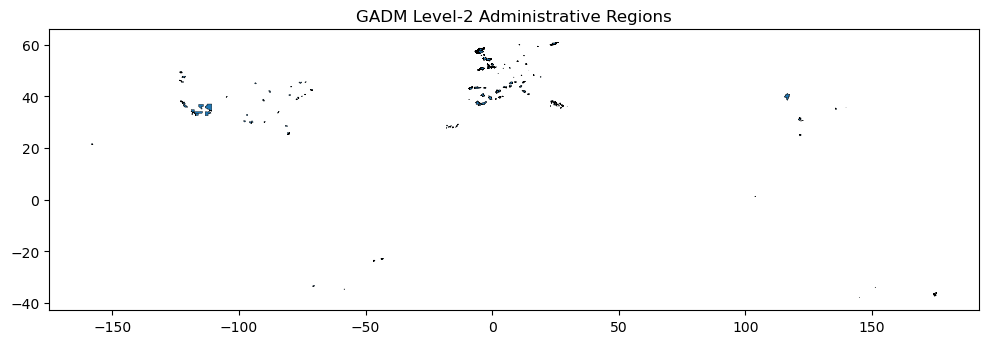

In [7]:
heavy_gdf.plot(figsize=(12, 8), edgecolor='black', linewidth=0.3)
plt.title("GADM Level-2 Administrative Regions")
plt.show()

In [8]:
sorted_gdf = gdf.sort_values('image_count', ascending=False)
print(sorted_gdf[['GID_0', 'NAME_0', 'GID_2', 'NAME_2', 'image_count']].head(20))


      GID_0          NAME_0         GID_2                NAME_2  image_count
4219    GBR  United Kingdom    GBR.1.36_1        Greater London       108193
11962   USA   United States   USA.33.32_1              New York        64459
12989   USA   United States    USA.5.38_1         San Francisco        55644
4068    FRA          France     FRA.8.3_1                 Paris        50535
12968   USA   United States    USA.5.19_1           Los Angeles        43774
3868    ESP           Spain     ESP.6.1_1             Barcelona        40248
12884   USA   United States   USA.48.17_1                  King        34932
11055   USA   United States   USA.14.16_1                  Cook        34597
3444    DEU         Germany     DEU.3.1_1                Berlin        33578
13177   USA   United States     USA.9.1_1  District of Columbia        28450
3874    ESP           Spain     ESP.8.1_1                Madrid        28090
2307    CAN          Canada    CAN.9.50_1               Toronto        23709

In [9]:
geometry = [Point(xy) for xy in zip(df_images['LON'], df_images['LAT'])]
df_images_gdf = gpd.GeoDataFrame(df_images, geometry=geometry, crs="EPSG:4326")
sindex = df_images_gdf.sindex
gdf_3857 = gdf.to_crs(3857)

In [10]:
def get_points_in_polygon(poly, pts_gdf):
    cand_idx = list(sindex.intersection(poly.bounds))

    if not cand_idx:
        return pts_gdf.iloc[0:0]

    candidates = pts_gdf.iloc[cand_idx]
    inside = candidates[candidates.within(poly)]
    return inside

In [14]:
def split_geocell(i, gdf):
    coords = get_points_in_polygon(gdf.iloc[i].geometry, df_images_gdf)

    images_gdf_3857 = coords.to_crs(3857)

    coords_3857 = pd.DataFrame([(p.x, p.y) for p in images_gdf_3857.geometry])

    optics = OPTICS(max_eps=1000, min_samples=50)
    y_predict = optics.fit_predict(coords_3857[[0,1]])
    coords_3857[2] = y_predict
    coords_3857.head()

    centroids = coords_3857[coords_3857[2] != -1].groupby(2)[[0, 1]].mean()

    vor = Voronoi(centroids)

    minx, miny = coords_3857[[0,1]].min(axis=0) - 1000
    maxx, maxy = coords_3857[[0,1]].max(axis=0) + 1000
    bounds = box(minx, miny, maxx, maxy)

    lines = []
    for (p1, p2) in vor.ridge_vertices:
        if p1 >= 0 and p2 >= 0:
            lines.append(LineString([vor.vertices[p1], vor.vertices[p2]]))
    
    merged = unary_union(lines)
    polys = list(polygonize(merged))

    clipped = [poly.intersection(bounds) for poly in polys]
    final = [p for p in clipped if not p.is_empty and p.geom_type == "Polygon"]
    print(final)
    final = [MultiPolygon([poly]) for poly in final]

    subcells = gpd.GeoDataFrame(geometry=gpd.GeoSeries(final, crs=3857).to_crs("EPSG:4326"))
    subcells["GID_2"] = gdf.iloc[i]["GID_2"]
    subcells["NAME_2"] = ""
    for count in range(len(subcells)):
        subcells.loc[subcells.index[count], "NAME_2"] = gdf.iloc[i]["NAME_2"] + "_" + str(count)
    subcells["GID_1"] = gdf.iloc[i]["GID_1"]
    subcells["NAME_1"] = gdf.iloc[i]["NAME_1"]
    subcells["GID_0"] = gdf.iloc[i]["GID_0"]
    subcells["NAME_0"] = gdf.iloc[i]["NAME_0"]
    subcells["image_count"] = 0

    subcells = subcells[['GID_2', 'NAME_2', 'GID_1', 'NAME_1', 'GID_0', 'NAME_0', 'image_count', 'geometry']]

    return subcells

[<POLYGON ((-478226.064 7531370.521, -478166.951 7531359.953, -476522.861 752...>, <POLYGON ((-478226.064 7531370.521, -478942.203 7533113.087, -477085.73 7532...>, <POLYGON ((-478166.951 7531359.953, -476802.56 7531558.489, -476409.883 7531...>, <POLYGON ((-476522.861 7528041.695, -475995.539 7528264.837, -473857.719 752...>, <POLYGON ((-476409.883 7531379.357, -476148.69 7532938.168, -474831.076 7533...>, <POLYGON ((-475935.846 7531014.815, -474831.076 7533021.076, -474516.054 753...>, <POLYGON ((-476802.56 7531558.489, -477085.73 7532501.909, -476746.374 75333...>, <POLYGON ((-475709.507 7530508.945, -475461.254 7530599.838, -473751.791 753...>, <POLYGON ((-476148.69 7532938.168, -476746.374 7533378.817, -476820.807 7533...>, <POLYGON ((-478942.203 7533113.087, -479324.527 7533624.859, -476820.807 753...>, <POLYGON ((-468726.064 7544784.067, -466599.892 7544784.067, -471979.551 753...>, <POLYGON ((-471979.551 7532929.542, -471928.66 7530738.318, -472631.541 7530...>, <POLYGON ((-471

/opt/anaconda3/lib/python3.13/site-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


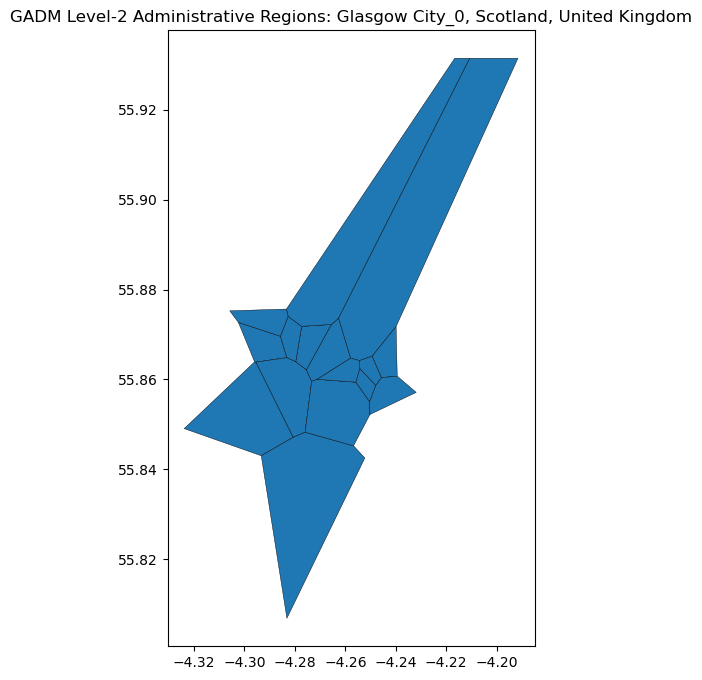

Processing geocells:  49%|████▊     | 53/109 [14:16<07:50,  8.40s/it]

In [ ]:
index_list = heavy_gdf.index.tolist()
total_subcells = gpd.GeoDataFrame()
for i in tqdm(index_list, desc="Processing geocells"):
    clear_output(wait=True)
    subcells = split_geocell(i, gdf)
    subcells.plot(figsize=(12, 8), edgecolor='black', linewidth=0.3)
    plt.title("GADM Level-2 Administrative Regions: " + subcells.iloc[0]['NAME_2'] + ", " + subcells.iloc[0]['NAME_1']+ ", " + subcells.iloc[0]['NAME_0'])
    total_subcells = pd.concat([subcells, total_subcells], ignore_index=True)
    plt.show()

In [21]:
new_gdf = gdf[~gdf.index.isin(heavy_gdf.index)]
new_gdf = pd.concat([new_gdf, total_subcells], ignore_index=True)

In [28]:
geometry = [Point(xy) for xy in zip(df_images['LON'], df_images['LAT'])]
gdf_images = gpd.GeoDataFrame(df_images, geometry=geometry, crs="EPSG:4326")

joined = gpd.sjoin(gdf_images, gdf, how='left', predicate='within')

image_counts = joined.groupby(joined.index_right).size()

new_gdf['image_count'] = new_gdf.index.map(image_counts).fillna(0).astype(int)

In [25]:
new_gdf.to_file("../resources/gadm_split.gpkg", driver='GPKG')